## Predicting UK House Prices

In [1]:
# import dependencies 
from pyspark.sql import SparkSession
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("HousePricePrediction") \
    .getOrCreate()

# Load data from a CSV file into a Spark DataFrame
file_path = '../Data/finalised.csv'
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Convert Spark DataFrame to Pandas DataFrame
df = df_spark.toPandas()

# Convert 'Date' to datetime format and extract useful features
df['Date'] = pd.to_datetime(df['Date'])

# Drop 'Date' column and any other non-numeric columns that should not be part of the features
df = df.drop(columns=['Date', 'AreaCode']) 

# Display the first few rows of the DataFrame
df.head()


,RegionName,AveragePrice,Index,IndexSA,1m%Change,12m%Change,AveragePriceSA,SalesVolume,DetachedPrice,DetachedIndex,...,NewPrice,NewIndex,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume
0,East Midlands,137536.5355,89.501836,89.73525,-1.036673,0.856126,137895.2167,3447.0,200466.4154,89.423104,...,173897.6555,86.715297,-3.977678,0.034394,217.0,134817.7424,89.798194,-0.712662,0.945563,3230.0
1,East Midlands,137599.2999,89.542680,89.74266,0.045635,1.099802,137906.6118,3522.0,200483.5222,89.430735,...,175581.5732,87.554994,0.968338,0.532139,307.0,134753.3618,89.755312,-0.047754,1.167650,3215.0
2,East Midlands,138561.8313,90.169047,90.19189,0.699518,1.121401,138596.9279,4585.0,202609.4709,90.379068,...,180069.6051,89.792983,2.556095,1.854837,572.0,135444.0406,90.215353,0.512550,1.060622,4013.0
3,East Midlands,139314.2861,90.658707,90.45051,0.543046,0.631746,138994.3555,4258.0,203308.7097,90.690981,...,179464.4630,89.491225,-0.336060,1.104084,390.0,136301.2755,90.786333,0.632907,0.593136,3868.0
4,East Midlands,141012.3511,91.763722,90.93737,1.218874,1.997612,139742.5070,5780.0,205321.7128,91.588932,...,181727.5737,90.619741,1.261036,2.393503,501.0,137956.7711,91.889010,1.214586,1.967697,5279.0


In [3]:
# Normalize/Standardize Numerical Features
numerical_cols = [
    'DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 
    'FlatPrice', 'SalesVolume', 'NewPrice', 'OldPrice'
]
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [4]:
# Encode Categorical Variables
categorical_cols = ['RegionName']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [5]:
# Define the target variable
y = df['AveragePrice']

# Define different feature sets
feature_sets = {
    "Set 1": ['DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice'],
    "Set 2": ['DetachedPrice', 'SemiDetachedPrice', 'FlatPrice'],
    "Set 3": ['DetachedPrice', 'TerracedPrice', 'FlatPrice'],
    "Set 4": df.drop(columns=['AveragePrice']).columns.tolist()  # All features except the target
}

In [6]:
def train_and_evaluate(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the model
    model = RandomForestRegressor(random_state=42)

    # Define the hyperparameters and their values
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }

    # Implement GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Evaluate the model on the test set
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)

    return best_model, best_params, best_score, test_score


In [18]:
results = {}
for set_name, features in feature_sets.items():
    print(f"Evaluating {set_name}...")
    X = df[features]
    best_model, best_params, best_score, test_score = train_and_evaluate(X, y)
    results[set_name] = {
        "Best Parameters": best_params,
        "Cross-Validation R-squared Score": best_score,
        "Test R-squared Score": test_score
    }

# Print the results
for set_name, result in results.items():
    print(f"\nResults for {set_name}:")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Best Cross-Validation R-squared Score: {result['Cross-Validation R-squared Score']:.4f}")
    print(f"Test R-squared Score: {result['Test R-squared Score']:.4f}")

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')

# Save the DataFrame to a CSV file
results_file_path = '../data/model_evaluation_results.csv'
results_df.to_csv(results_file_path)

print(f"Results saved to {results_file_path}")

Evaluating Set 1...
Evaluating Set 2...
Evaluating Set 3...
Evaluating Set 4...

Results for Set 1:
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation R-squared Score: 0.9990
Test R-squared Score: 0.9992

Results for Set 2:
Best Parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation R-squared Score: 0.9978
Test R-squared Score: 0.9974

Results for Set 3:
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation R-squared Score: 0.9990
Test R-squared Score: 0.9991

Results for Set 4:
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation R-squared Score: 0.9999
Test R-squared Score: 0.9999
Results saved to ../data/model_evaluation_results.csv


#### Analysis of Model Performance with Different Feature Sets
To understand how different combinations of features affect the model's accuracy, we tested four different sets of features. Here’s a simple breakdown of the results:

##### Set 1: ['DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice']

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}

Cross-Validation R-squared Score: 0.9990
Test R-squared Score: 0.9992

What this means: Including prices for all major property types gives a very accurate model. This set captures a broad range of factors influencing house prices.

##### Set 2: ['DetachedPrice', 'SemiDetachedPrice', 'FlatPrice']

- Best Parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300}
- Cross-Validation R-squared Score: 0.9978
- Test R-squared Score: 0.9974

What this means: Removing 'TerracedPrice' slightly reduces accuracy, suggesting that terraced house prices provide additional useful information.

##### Set 3: ['DetachedPrice', 'TerracedPrice', 'FlatPrice']

- Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
- Cross-Validation R-squared Score: 0.9990
- Test R-squared Score: 0.9991

What this means: Removing 'SemiDetachedPrice' also slightly reduces accuracy, indicating that semi-detached house prices are also important.

##### Set 4: All features except 'Date' and 'AreaCode'

- Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
- Cross-Validation R-squared Score: 0.9999
- Test R-squared Score: 0.9999

What this means: Including all available features gives the best results. This shows that a comprehensive set of features provides the most accurate predictions.

#### Conclusion
##### High Accuracy:

All feature sets gave very high accuracy, with R-squared scores close to 1.0.

##### Best Performance:

The feature set with all available features (Set 4) performed the best. This means using more features gives the most accurate predictions.

##### Important Features:

Prices of different property types (Detached, Semi-Detached, Terraced, Flats) are crucial for predicting house prices. Each type adds valuable information.

##### Robust Model:

The Random Forest model is very reliable and performs well across different feature sets.


## Visualizations for Model Results

### Actual vs Predicted Prices

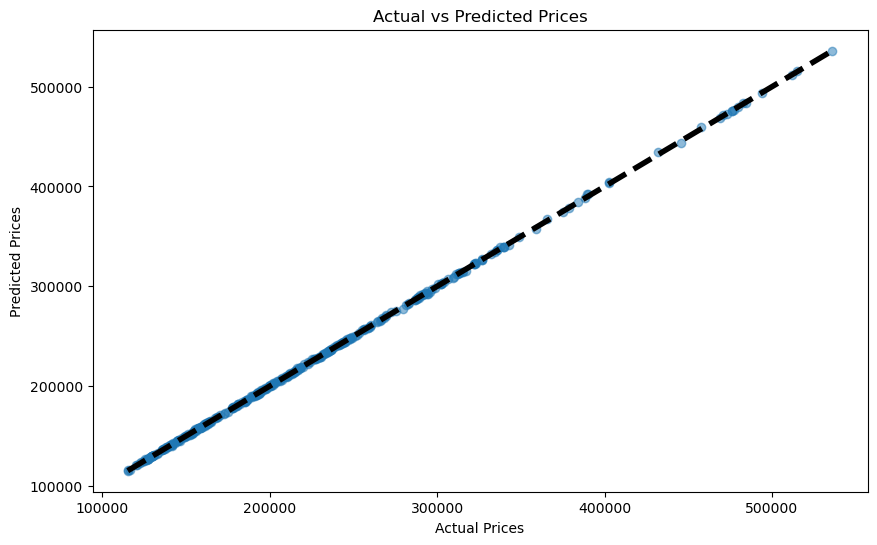

In [19]:
# Function to plot Actual vs Predicted Prices
def plot_actual_vs_predicted(y_test, y_pred, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs Predicted Prices')
    
    if save_path:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        
    plt.show()

# Using the best model from the last set (Set 4) for predictions and plots
best_model, _, _, _ = train_and_evaluate(df[feature_sets['Set 4']], y)
X_train, X_test, y_train, y_test = train_test_split(df[feature_sets['Set 4']], y, test_size=0.2, random_state=42)
y_pred = best_model.predict(X_test)

# Plot and display the visualizations
plot_actual_vs_predicted(y_test, y_pred, save_path='../Output/actual_vs_predicted.png')

### Residual Plot

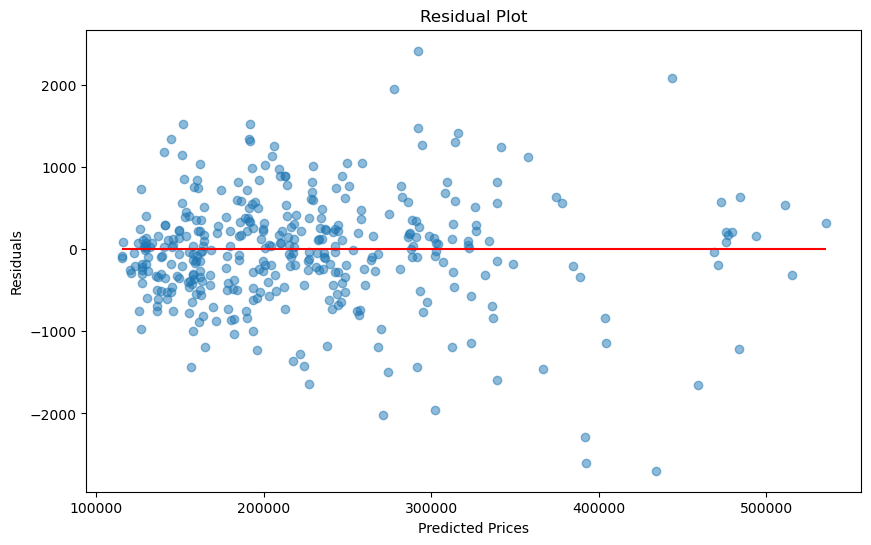

In [9]:
# Function to plot Residuals
def plot_residuals(y_test, y_pred, save_path=None):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='r')
    plt.xlabel('Predicted Prices')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    
    if save_path:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    
    plt.show()
    
# Plot and display the visualizations
plot_residuals(y_test, y_pred, save_path='../Output/residual_plot.png')

### Learning Curve

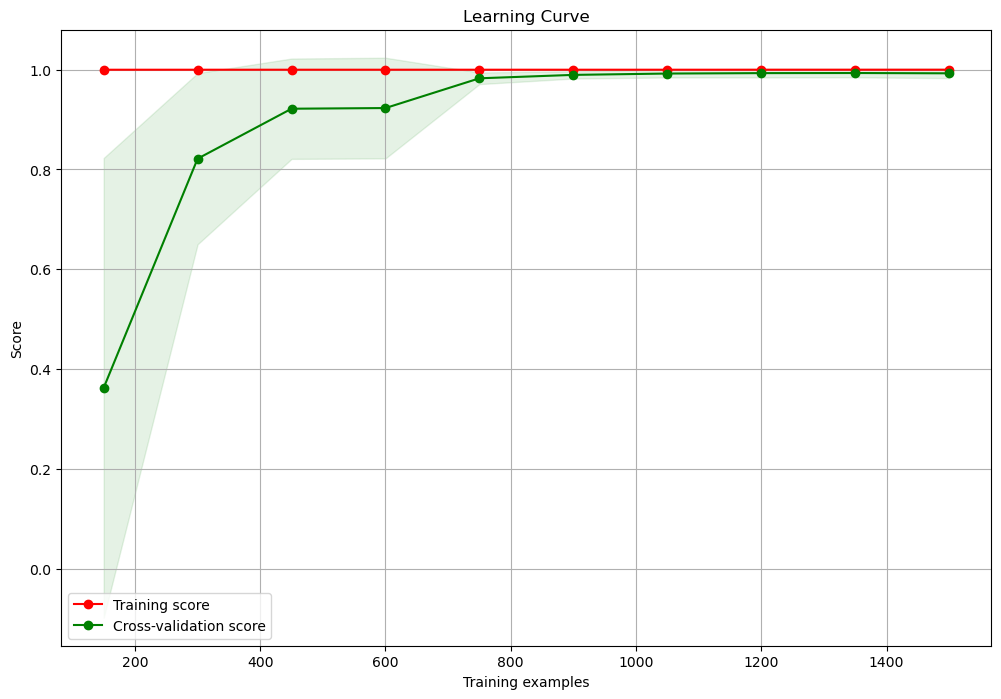

In [10]:
# Function to plot learning curve
def plot_learning_curve(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), save_path=None):
    plt.figure(figsize=(12, 8))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    
    if save_path:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    
    plt.show()
    
# Plot and display the visualizations
plot_learning_curve(best_model, df[feature_sets['Set 4']], y, save_path='../Output/learning_curve.png')


### Feature Importance Plot

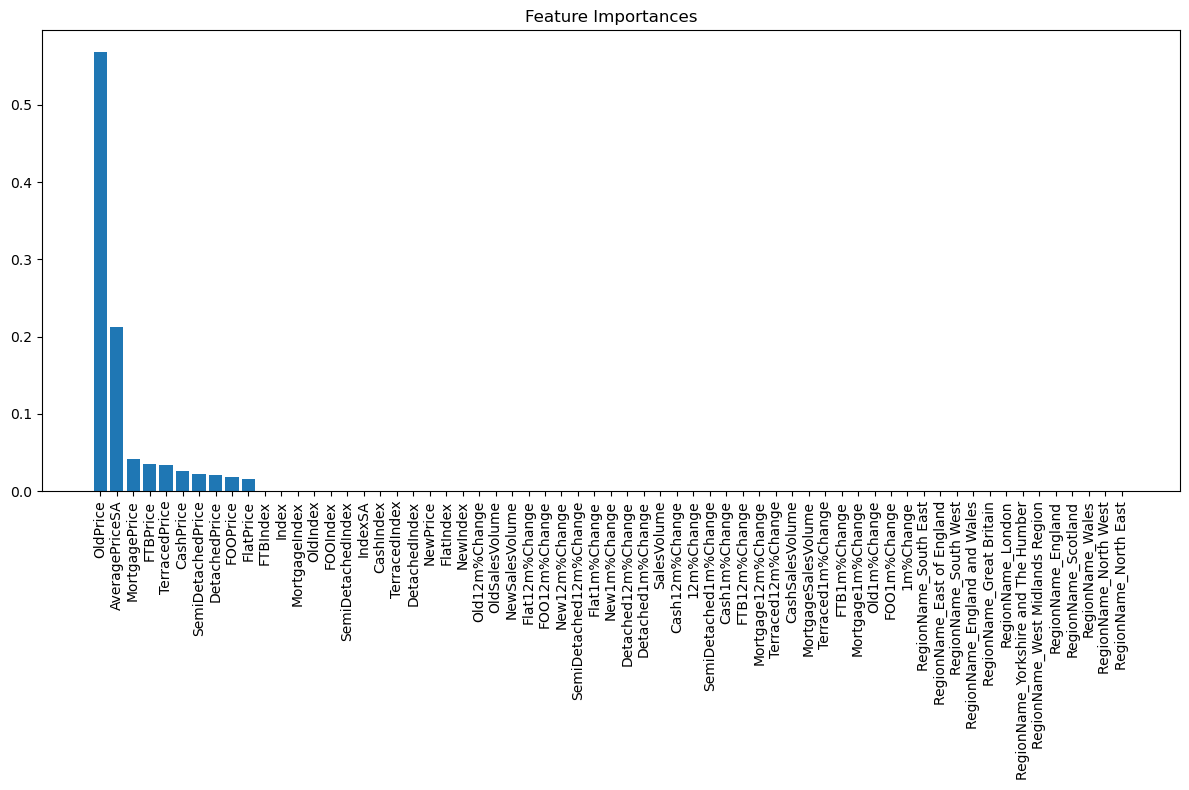

In [11]:
# Function to plot Feature Importances
def plot_feature_importances(model, feature_names, save_path=None):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
    plt.tight_layout()
    
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    
    plt.show()
    
plot_feature_importances(best_model, df[feature_sets['Set 4']].columns, save_path='../Output/feature_importances.png')

### Error Distribution

C:\Users\nj_al\anaconda3\anaconda\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


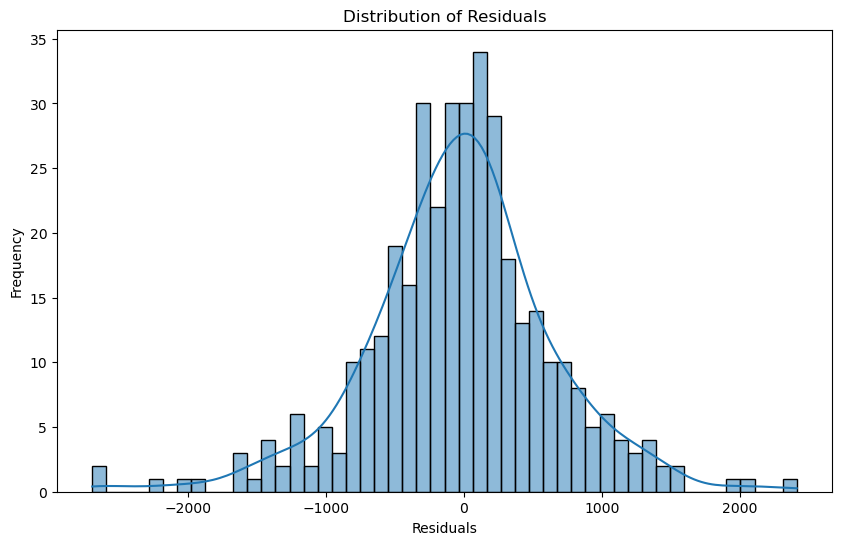

In [12]:
# Function to plot Error Distribution
def plot_error_distribution(y_test, y_pred, save_path=None):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, bins=50, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    
    if save_path:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    
    plt.show()

# Plot and display the visualizations
plot_error_distribution(y_test, y_pred, save_path='../Output/error_distribution.png')

In [13]:
# Save the final DataFrame to a CSV file
output_file_path = '../data/HousePrices_Final.csv'
df.to_csv(output_file_path, index=False)
print(f"Data saved to {output_file_path}")


Data saved to ../data/HousePrices_Final.csv
